# Analisis Sentimen Ulasan Aplikasi Menggunakan LSTM
**Tugas Proyek Deep Learning**

Anggota Kelompok:
1. [Arip]
2. [Carol DP]
3. [Arya Pangestu]
4. [Rafdy Fauzan]

Notebook ini berisi tahapan preprocessing data, penyeimbangan kelas dataset (oversampling), pembangunan model Bidirectional LSTM, dan evaluasi model.

Info Data:
                  source                      username  rating  \
0  com.instagram.android                 Kholid Kholid       5   
1  com.instagram.android                 Adil Padillah       5   
2  com.instagram.android                   Dika Andika       4   
3  com.instagram.android                  Inces Cantik       5   
4  com.instagram.android  hafidz alief perdana (alwyy)       1   

                                         review_text                 date  
0                                    sangatt bagusss  2026-01-10 15:58:56  
1                                              okehh  2026-01-10 15:58:17  
2              bagus bener tapi suka buat kesel juga  2026-01-10 15:55:16  
3              Bermanfaat untuk digunakan yang baik'  2026-01-10 15:44:21  
4  KEHEDD AII SIAA NIAT TEUU KOPLOKK NYIEUN INSTA...  2026-01-10 15:38:27  
Class Weights: {0: np.float64(1.284796573875803), 1: np.float64(0.8185538881309686)}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
150/150 - 22s - 148ms/step - accuracy: 0.7923 - loss: 0.4778 - val_accuracy: 0.8750 - val_loss: 0.3536
Epoch 2/20
150/150 - 15s - 103ms/step - accuracy: 0.9135 - loss: 0.2739 - val_accuracy: 0.8875 - val_loss: 0.3207
Epoch 3/20
150/150 - 16s - 104ms/step - accuracy: 0.9371 - loss: 0.2155 - val_accuracy: 0.8717 - val_loss: 0.3582
Epoch 4/20
150/150 - 16s - 104ms/step - accuracy: 0.9527 - loss: 0.1742 - val_accuracy: 0.8600 - val_loss: 0.4200
Epoch 5/20
150/150 - 17s - 111ms/step - accuracy: 0.9646 - loss: 0.1423 - val_accuracy: 0.8667 - val_loss: 0.4321
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


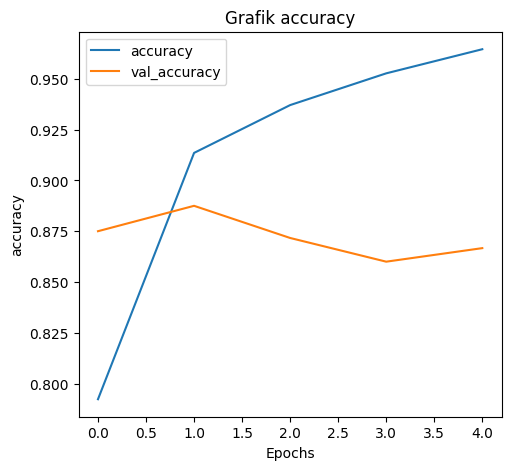

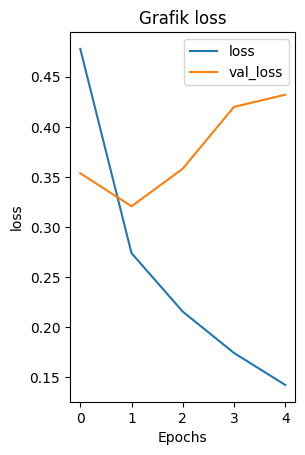


=== PENGUJIAN PREDIKSI ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
Teks: Aplikasinya sangat membantu, fiturnya lengkap.
Score: 0.9887 -> Prediksi: Positif

Teks: Loadingnya lama sekali, sering force close.
Score: 0.0893 -> Prediksi: Negatif

Teks: Biasa saja, standar seperti aplikasi lain.
Score: 0.1654 -> Prediksi: Negatif

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

Confusion Matrix:
[[417  50]
 [ 85 648]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       467
           1       0.93      0.88      0.91       733

    accuracy                           0.89      1200
   macro avg       0.88      0.89      0.88      1200
weighted avg       0.89      0.89      0.89      1200



In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

# ==========================================
# 1. LOAD DATA & PREPROCESSING
# ==========================================

df = pd.read_csv('dataset_mentah_playstore.csv')


print("Info Data:")
print(df.head())

X = df['review_text'].astype(str)

df['label'] = df['rating'].apply(lambda x: 1 if x >= 4 else 0)
y = df['label'].values

# Split Data (80% Train, 20% Test)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Tokenisasi
vocab_size = 5000
embedding_dim = 100
max_length = 100
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train_raw)

# Konversi teks ke sequence angka
X_train = tokenizer.texts_to_sequences(X_train_raw)
X_test = tokenizer.texts_to_sequences(X_test_raw)

# Padding agar panjangnya sama
X_train_pad = pad_sequences(X_train, maxlen=max_length, padding=padding_type, truncating=trunc_type)
X_test_pad = pad_sequences(X_test, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# ==========================================
# 2. MENGATASI IMBALANCED DATA
# ==========================================
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
weights_dict = dict(enumerate(class_weights))
print(f"Class Weights: {weights_dict}")

# ==========================================
# 3. MEMBANGUN MODEL
# ==========================================
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),

    # Bidirectional LSTM agar membaca konteks kiri-kanan
    Bidirectional(LSTM(64, return_sequences=False)),

    # Dropout untuk mencegah Overfitting (Grafik Loss naik)
    Dropout(0.5),

    Dense(32, activation='relu'),
    Dropout(0.5),

    # Output layer (1 neuron untuk Binary Classification)
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# ==========================================
# 4. TRAINING
# ==========================================

# EarlyStopping: Berhenti otomatis jika validasi loss memburuk
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

num_epochs = 20 # Set tinggi saja, nanti early_stop yang akan memberhentikan

history = model.fit(
    X_train_pad, y_train,
    epochs=num_epochs,
    validation_data=(X_test_pad, y_test),
    class_weight=weights_dict,
    callbacks=[early_stop],
    verbose=2
)

# ==========================================
# 5. PLOTTING GRAFIK (EVALUASI)
# ==========================================
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.title(f"Grafik {string}")
    plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_graphs(history, "accuracy")
plt.subplot(1, 2, 2)
plot_graphs(history, "loss")

# ==========================================
# 6. TESTING PREDIKSI MANUAL (VALIDASI LOGIKA)
# ==========================================
print("\n=== PENGUJIAN PREDIKSI ===")
input_text = [
    "Aplikasinya sangat membantu, fiturnya lengkap.",
    "Loadingnya lama sekali, sering force close.",
    "Biasa saja, standar seperti aplikasi lain."
]

# Preprocessing input manual
seq = tokenizer.texts_to_sequences(input_text)
padded = pad_sequences(seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Prediksi
preds = model.predict(padded)

for i, text in enumerate(input_text):
    score = preds[i][0]
    label = "Positif" if score > 0.5 else "Negatif"
    print(f"Teks: {text}")
    print(f"Score: {score:.4f} -> Prediksi: {label}\n")

# Cek Confusion Matrix untuk melihat detail kesalahan
y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

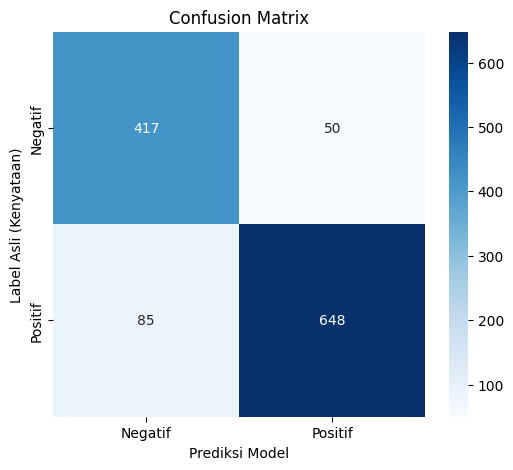

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1. Hitung Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# 2. Buat Plot Gambar
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])

# 3. Beri Label agar jelas
plt.xlabel('Prediksi Model')
plt.ylabel('Label Asli (Kenyataan)')
plt.title('Confusion Matrix')

# 4. Tampilkan
plt.show()

In [15]:
from sklearn.metrics import accuracy_score

# ... (kode prediksi sebelumnya) ...

# Hitung akurasi dalam bentuk angka
acc = accuracy_score(y_test, y_pred)

# TAMPILKAN HASIL AKHIR YANG JELAS UNTUK DOSEN
print("="*40)
print(f"✅ AKURASI FINAL MODEL: {acc * 100:.2f}%")
print("="*40)

print("\nDetail Laporan Klasifikasi:")
print(classification_report(y_test, y_pred, digits=4)) # digits=4 agar angka desimalnya lebih presisi

✅ AKURASI FINAL MODEL: 88.75%

Detail Laporan Klasifikasi:
              precision    recall  f1-score   support

           0     0.8307    0.8929    0.8607       467
           1     0.9284    0.8840    0.9057       733

    accuracy                         0.8875      1200
   macro avg     0.8795    0.8885    0.8832      1200
weighted avg     0.8903    0.8875    0.8882      1200

